# taq_cross_response_transactions_test

#### Juan Camilo Henao Londono - 21.05.2019
#### AG Guhr - Universitaet Duisburg-Essen

In [1]:
# Modules

import numpy as np
import os
import pickle

__tau__ = 1000
__case__ = 'juan' # 'juan' or 'wang'
__returns__ = 'ret' # 'ret' or 'log'

In [2]:
def taq_trade_signs_all_transactions_data(ticker, year, month, day, model=__case__):
    """
    Obtain the trade signs from the TAQ data. The trade signs are calculated
    using the equation (1) of https://arxiv.org/pdf/1603.01580.pdf.
    As the trades signs are not directly given by the TAQ data, they must be
    infered by the trades prices. For further calculations we use the whole
    time range from the opening of the market at 9h40 to the closing at 15h50
    in seconds (22200 seconds).
        :param ticker: string of the abbreviation of the stock to be analized
         (i.e. 'AAPL')
        :param year: string of the year to be analized (i.e '2016')
        :param month: string of the month to be analized (i.e '07')
        :param day: string of the day to be analized (i.e '07')
    """''

    # Load data

    time_t, ask_t = pickle.load(open(
        '../TAQ_2008/TAQ_py/TAQ_{}_trades_{}{}{}.pickle'
        .format(ticker, year, month, day), 'rb'))

    # Reproducing S. Wang values. In her results the time interval for the
    # trade signs is [34801, 57000]
    if (model == 'juan'):
        condition = time_t != 57000
    elif (model == 'wang'):
        condition = time_t != 34800
        
    time_t = time_t[condition]
    ask_t = ask_t[condition]

    # All the trades must have a price different to zero
    assert not np.sum(ask_t == 0)

    # Trades identified using equation (1)
    identified_trades = np.zeros(len(time_t))
    identified_trades[-1] = 1

    # Implementation of equation (1). Sign of the price change between
    # consecutive trades

    for t_idx, t_val in enumerate(time_t):

        diff = ask_t[t_idx] - ask_t[t_idx - 1]

        if (diff):

            identified_trades[t_idx] = np.sign(diff)

        else:

            identified_trades[t_idx] = identified_trades[t_idx - 1]

    # All the identified trades must be different to zero
    assert not np.sum(identified_trades == 0)

    return (time_t, ask_t, identified_trades)

In [3]:
def taq_midpoint_all_transactions_data(ticker, year, month, day):
    """
    Obtain the midpoint price from the TAQ data for all the transactions.
    For further calculations we use the full time range from 9h40 to 15h50 in
    seconds (22200 seconds).
    Return best bid, best ask, spread, midpoint price and time.
        :param ticker: string of the abbreviation of the stock to be analized
                       (i.e. 'AAPL')sys
        :param year: string of the year to be analized (i.e '2008')
        :param month: string of the month to be analized (i.e '07')
        :param day: string of the day to be analized (i.e '07')
    """

    # Load data
    # TAQ data gives directly the quotes data in every second that there is
    # a change in the quotes
    time_q_, bid_q_, ask_q_ = pickle.load(open(
        '../TAQ_2008/TAQ_py/TAQ_{}_quotes_{}{}{}.pickle'
        .format(ticker, year, month, day), 'rb'))

    # Some files are corrupted, so there are some zero values that
    # does not have sense
    condition_1 = ask_q_ != 0.
    time_q = time_q_[condition_1]
    bid_q = bid_q_[condition_1]
    ask_q = ask_q_[condition_1]
    # Reproducing S. Wang values. In her results the time interval for the
    # midpoint is [34800, 56999]
    condition_2 = time_q != 57000
    time_q = time_q[condition_2]
    bid_q = bid_q[condition_2]
    ask_q = ask_q[condition_2]

    assert len(bid_q) == len(ask_q)

    midpoint = (bid_q + ask_q) / 2
    spread = ask_q - bid_q

    return time_q, bid_q, ask_q, midpoint, spread

In [4]:
def taq_midpoint_full_time_data(ticker, year, month, day):
    """
    Obtain the midpoint price from the TAQ data for a complete day. For further
    calculations we use the full time range from 9h40 to 15h50 in seconds
    (22200 seconds). To fill the time spaces when nothing happens we replicate
    the last value calculated until a change in the price happens. Save in a
    different pickle file the array of each of the following values: best bid,
    best ask, spread, midpoint price and time. Return midpoint price array.
        :param ticker: string of the abbreviation of the stock to be analized
                       (i.e. 'AAPL')
        :param year: string of the year to be analized (i.e '2008')
        :param month: string of the month to be analized (i.e '07')
        :param day: string of the day to be analized (i.e '07')
    """

    (time_q, bid_q, ask_q,
     midpoint, spread) = taq_midpoint_all_transactions_data(ticker, year,
                                                            month, day)

    # 34800 s = 9h40 - 57000 s = 15h50
    # Reproducing S. Wang values. In her results the time interval for the
    # midpoint is [34800, 56999]
    full_time = np.array(range(34800, 57000))

    # As there can be several values for the same second, we use the
    # last value of each second in the full time array as it behaves
    # quiet equal as the original input

    midpoint_last_val = 0. * full_time
    midpoint_last_val[-1] = midpoint[0]

    ask_last_val = 0. * full_time
    ask_last_val[-1] = ask_q[0]

    bid_last_val = 0. * full_time
    bid_last_val[-1] = bid_q[0]

    spread_last_val = 0. * full_time
    spread_last_val[-1] = spread[0]

    count = 0

    for t_idx, t_val in enumerate(full_time):

        length = len(time_q)

        if (count < length and t_val == time_q[count]):

            count += 1

            while (count < length and
                   time_q[count - 1] == time_q[count]):

                count += 1

            midpoint_last_val[t_idx] = midpoint[count - 1]
            ask_last_val[t_idx] = ask_q[count - 1]
            bid_last_val[t_idx] = bid_q[count - 1]
            spread_last_val[t_idx] = spread[count - 1]

        else:

            midpoint_last_val[t_idx] = midpoint_last_val[t_idx - 1]
            ask_last_val[t_idx] = ask_last_val[t_idx - 1]
            bid_last_val[t_idx] = bid_last_val[t_idx - 1]
            spread_last_val[t_idx] = spread_last_val[t_idx - 1]

    # There should not be 0 values in the midpoint array
    assert not np.sum(midpoint_last_val == 0)

    return full_time, midpoint_last_val

In [5]:
ticker_i = 'AAPL'
ticker_j = 'MSFT'
year = '2008'
month = '01'
day = '07'

time_m, midpoint = taq_midpoint_full_time_data(ticker_i, year, month, day)
time_t, _, identified_trades = taq_trade_signs_all_transactions_data(ticker_j, year, month, day)

In [6]:
def taq_cross_response_data(time_m, midpoint, time_t, identified_trades, *, mod=__returns__):
    """
    Obtain the cross response function using the midpoint log returns of
    ticker i and trade signs of ticker j during different time lags. The data
    is adjusted to use only the values each second. Return an array with the
    cross response function.
        :param ticker_i: string of the abbreviation of the midpoint stock to
         be analized (i.e. 'AAPL')
        :param ticker_j: string of the abbreviation of the trade sign stock to
         be analized (i.e. 'AAPL')
        :param year: string of the year to be analized (i.e '2016')
        :param month: string of the month to be analized (i.e '07')
        :param day: string of the day to be analized (i.e '07')
        :param mod='log': select the midpoint price return. 'ret' for midpoint
         price return and 'log' for midpoint price log return. Default 'log'
    """

    assert not np.sum(identified_trades[identified_trades == 0])
    
    # Array of the average of each tau. 10^3 s used by Wang
    cross_response_tau = np.zeros(__tau__)

    # Calculating the midpoint log return and the cross response function
    
    midpoint_t = 0 * identified_trades
    for t_idx, t_val in enumerate(time_m):
        condition = t_val == time_t
        len_c = np.sum(condition)
        midpoint_t[condition] = midpoint[t_idx] * np.ones(len_c)
    
    # Depending on the tau value
    for tau_idx in range(__tau__):

        trade_sign_tau = 1 * identified_trades[:-tau_idx - 1]
        trade_sign_no_0_len = len(trade_sign_tau)
        # Obtain the midpoint log return. Displace the numerator tau
        # values to the right and compute the return
        
    
        assert not np.sum(midpoint_t == 0)

        # midpoint price log returns
        if (mod == 'log'):
            log_return_i_sec = np.log(midpoint_t[tau_idx + 1:]
                                      / midpoint_t[:-tau_idx - 1])

        # midpoint price returns
        elif (mod == 'ret'):

            log_return_i_sec = (midpoint_t[tau_idx + 1:]
                                - midpoint_t[:-tau_idx - 1]) \
                / midpoint_t[:-tau_idx - 1]

        # Obtain the cross response value
        if (trade_sign_no_0_len != 0):
            product = log_return_i_sec * trade_sign_tau
            cross_response_tau[tau_idx] = (np.sum(product)
                                           / trade_sign_no_0_len)

    return cross_response_tau

In [7]:
%%timeit
taq_cross_response_data(time_m, midpoint, time_t, identified_trades)

3.38 s ± 36.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<function matplotlib.pyplot.show(*args, **kw)>

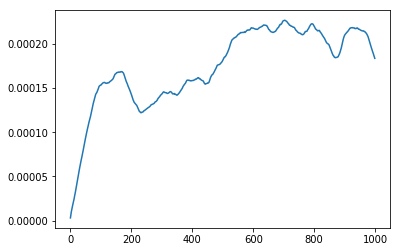

In [9]:
from matplotlib import pyplot as plt

plt.plot(taq_cross_response_data(time_m, midpoint, time_t, identified_trades))
plt.show